# Evaluating a model

This notebook demonstrates evaluating a trained model by exploring the results on the independent set of data, and displaying the training process.

It is important to explore more than the loss produced during training in order to evaluate a model. Especially in the context of ML applied to science where it is not common that the underlying task to solve is "minimize the RMSE" and instead more likely to be "Predict the height layer level of a cloud base" where root mean square error between the desired output and the model output can help to understand how well the underlying task is going, more evaluation is required for a better picture of the model.

Evaluation is explored through recalling the training process, producing classical metrics, as well as custom metrics designed for the current task (in our case SEDI and SEDS). More evaluation could be considered in order to explore the exact cases in which the model fails or implementing techniques for explainability of the model for better interpretation of the results.

additionally, some testing of bespoke evaluation to ensure refactoring from the base solution is consistent with previous implementations of evaluation is performed

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import torch
import zarr
from sklearn.metrics import confusion_matrix

import cbh_data_definitions
import cbh_torch_MLP
import cbh_torch_lstm  # defined in directory (model definition)
import mlflow

## Define and initialize the evaluation data

In [3]:
root_data_directory = pathlib.Path(os.environ["SCRATCH"]) / "cbh_data"
test_data_path = (
    root_data_directory / "analysis_ready" / "dev.zarr"
)  # must change with available test data

In [4]:
test_input, test_labels, test_cloud_volume = cbh_data_definitions.load_data_from_zarr(
    test_data_path
)
print(test_labels.chunksize[0])
print(len(test_labels))

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 

102400
307200


In [5]:
collate_fn = cbh_data_definitions.dataloader_collate_with_dask
batch_size = int(test_labels.chunksize[0] / 4)
workers_on_system = 0
CPU_COUNT=4
data_loader_hparam_dict = {
    'batch_size':batch_size,
    'num_workers':workers_on_system,
    'pin_memory':False,
    'collate_fn':collate_fn,
}
test_dataset = cbh_data_definitions.CBH_Dataset_Load_One_Chunk(
    test_input,
    test_labels,
    threads=CPU_COUNT
)


In [6]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, **data_loader_hparam_dict)

## Recall a trained model, for this step a particular mlflow experiment is chosen from mlflow_artifacts to evaluate (defined in the cell below)

In [8]:
model_run_hash = '518b1de12d234339bf1fe4bf38ca51ae'
checkpoint_path = "./mlflow_artifacts/1/518b1de12d234339bf1fe4bf38ca51ae/artifacts/518b1de12d234339bf1fe4bf38ca51ae-best_model_checkpoint-step_12313.pt"

In [9]:
chkpt = torch.load(checkpoint_path)
print(chkpt.keys())

dict_keys(['val loss', 'train loss at step-1', 'global_step', 'model_state_dict', 'checkpoint'])


In [10]:
from tempfile import TemporaryDirectory
with TemporaryDirectory() as tmpdirname:
    tempfile = tmpdirname + '/ckhpt'
    torch.save(chkpt['checkpoint'], tempfile)
    model = cbh_torch_MLP.CloudBaseMLP.load_from_checkpoint(tempfile)
model.eval()

CloudBaseMLP(
  (layer_norm): LayerNorm((210,), eps=1e-05, elementwise_affine=True)
  (linears): ModuleList(
    (0): Linear(in_features=210, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=70, bias=True)
  )
  (normalize_outputs): Softmax(dim=None)
  (crossentropy_loss): CrossEntropyLoss()
)

## Get model predictions for Eval
loop through all of the test data, collecting the targets and the model predictions.

In [11]:
%%time
all_preds = np.empty(0)
all_targs = np.empty(0)
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    x = torch.flatten(x, start_dim=1)
    batch_preds = model(x)  # self call = forward
    class_prediction = np.argmax(batch_preds.detach().numpy(), axis=1)
    all_preds = np.concatenate(
        (all_preds, class_prediction), axis=0
    )  # get second value only (since model doesn't support the other return per how it is currently defined)

print("Length of prediction output:", all_preds.shape)

print("Prediction output matches target output:", all_targs.shape == all_preds.shape)

Length of prediction output: (307200,)
Prediction output matches target output: True
CPU times: user 3min 5s, sys: 5.28 s, total: 3min 10s
Wall time: 3min 6s


Here a small subset of predictions and targets are given to give the reader an idea of the kind of outputs that come about for the task, then the outputs and targets are binned for a better idea of how the model operates. Due to the class imbalance of our task, it is likely that the model will overpredict the majority classes (0 and 69).

In [12]:
print("Show of some predictions :", all_preds[0:20])
print("Show of some targets, same samples:", all_targs[0:20])
print(
    "Model predictions binned: (Class labels), (Counts):",
    np.unique(all_preds, return_counts=True),
)
print(
    "Target labels binned: (Class labels), (Counts):",
    np.unique(all_targs, return_counts=True),
)
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))

Show of some predictions : [69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69.
 69. 69.]
Show of some targets, same samples: [16. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16.]
Model predictions binned: (Class labels), (Counts): (array([ 0., 69.]), array([128379, 178821]))
Target labels binned: (Class labels), (Counts): (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       69.]), array([48207,  7345,  6824,  6581,  6311,  5855,  6811,  8105,  8406,
        7745,  8055,  8211,  7782,  7082,  5604,  4535,  4367,  3159,
        2949,  2475,  2263,  2132,  2052,  2493,  3018,  4325,  3172,
        2532,  2182,  2454,  2408,  2293,  2251,  2644,  3003,  3200,
        3398,  3574,  3818,  3882,  2967,  

## Evaluate model returns
Next, more bespoke evaluation is performed using the metric of SEDI and SEDS for each height layer in the sample as well as more classical metrics: Accuracy, Mean Error, Mean Absolute Error, Root Mean Squared Error

In [13]:
def old_cbh_eval(preds, targs):
    # for all tested height layers
    abcd_list = []
    for k in np.arange(0, 53, 1):
        a = 0.0
        b = 0.0
        c = 0.0
        d = 0.0
        for i in np.arange(0, targs.shape[1]):
            # Is the cloud-base at this level or below.
            if targs[0, i] <= np.float64(k) and preds[0, i] <= np.float64(k):
                # Hit
                a = a + 1.0
            elif targs[0, i] > np.float64(k) and preds[0, i] <= np.float64(k):
                # False alarm
                b = b + 1.0
            elif targs[0, i] <= np.float64(k) and preds[0, i] > np.float64(k):
                # Miss
                c = c + 1.0
            else:
                # Correct negative
                d = d + 1.0
        if a == 0.0 or b == 0.0:
            a += 1
            b += 1
        abcd_list.append((a, b, c, d))
    return abcd_list


import typing


# new function
def new_cbh_eval(preds: typing.Iterable, targs: typing.Iterable, test_before_layer=53):

    batch_length = len(targs)
    cloud_height_expanded_array = np.column_stack(
        np.arange(test_before_layer)
    ).T.repeat(batch_length, 1)
    p = targs <= cloud_height_expanded_array
    q = preds <= cloud_height_expanded_array

    l = lambda x: x.sum(1)
    a = p & q
    b = np.logical_not(p) & q
    c = p & np.logical_not(q)
    d = np.logical_not(a | b | c)
    adjust = np.logical_not(a.any(1) & b.any(1))

    return list(
        zip(
            (np.where(adjust, l(a) + 1, l(a))),
            (np.where(adjust, l(b) + 1, l(b))),
            l(c),
            l(d),
        )
    )


# Test function equivalance
aa = [0, 1, 2, 3, 4, 4, 1]
bb = [0, 3, 1, 4, 1, 4, 1]
print(
    "Equiv. function on test subset?:",
    new_cbh_eval(all_preds[0:2000], all_targs[0:2000])
    == old_cbh_eval(np.array([all_preds[0:2000]]), np.array([all_targs[0:2000]])),
)
print(
    "Equiv. function on toy data?:",
    new_cbh_eval(aa, bb) == old_cbh_eval(np.array([aa]), np.array([bb])),
)
print("Time on new function, test data:", end=" ")
%timeit new_cbh_eval(all_preds, all_targs)
print("Time on old function, test data:", end=" ")
%timeit old_cbh_eval(np.array([all_preds]), np.array([all_targs]))
print("Time on new function, toy data:", end=" ")
%timeit new_cbh_eval(aa, bb)
print("Time on old function, toy data:", end=" ")
%timeit old_cbh_eval(np.array([aa]), np.array([bb]))

Equiv. function on test subset?: True
Equiv. function on toy data?: True
Time on new function, test data: 245 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time on old function, test data: 20.8 s ± 358 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time on new function, toy data: 181 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, toy data: 485 µs ± 5.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
abcd_list = new_cbh_eval(all_preds, all_targs)  # save the eval result

In [15]:
def calc_sedi_from_abcd_list(abcd_list):
    store_sedi, store_seds = ([], [])
    for a, b, c, d in abcd_list:
        n = a + b + c + d
        ar = ((a + b) * (a + c)) / n
        # Symmetric Extreme Dependency Score (SEDS) has advantage that it is 1.0 for perfect forecast
        # and 0.0 for no better than climatology
        # (unlike Equitable Threat Score [ETS] for which it is not clear at what point a low score means it is poor.
        seds = np.log(ar / a) / np.log(a / n)
        store_seds = np.append(store_seds, seds)
        # Also calculate SEDI from Ferro and Stephenson (equation 2)
        # https://journals.ametsoc.org/view/journals/wefo/26/5/waf-d-10-05030_1.xml
        h = a / (a + c)
        f = b / (b + d)
        top = np.log(f) - np.log(h) - np.log(1.0 - f) + np.log(1.0 - h)
        bottom = np.log(f) + np.log(h) + np.log(1.0 - f) + np.log(1.0 - h)
        sedi = top / bottom
        store_sedi = np.append(store_sedi, sedi)

    return store_sedi, store_seds


def calc_sedi_numpy(abcd_list):

    sed_arr = np.array(abcd_list)
    n = np.sum(sed_arr, axis=1)
    a = sed_arr[:, 0]
    b = sed_arr[:, 1]
    c = sed_arr[:, 2]
    d = sed_arr[:, 3]
    ar = ((a + b) * (a + c)) / n
    seds = np.log(ar / a) / np.log(a / n)

    h = a / (a + c)
    f = b / (b + d)
    top = np.log((f * (1.0 - h)) / (h * (1.0 - f)))
    bottom = np.log(f * h * (1.0 - f) * (1.0 - h))
    sedi = top / bottom

    return sedi, seds


# perform the same equiv. test but for sedi calculation from previous function output
sedi_list_new, seds_list_new = calc_sedi_numpy(abcd_list)
sedi_list_old, seds_list_old = calc_sedi_from_abcd_list(abcd_list)
print("Equiv. function for SEDS?:", np.array_equal(seds_list_new, seds_list_old))
print(
    "Equiv. function for SEDI? (possible differences of approx. 1e-16):",
    np.array_equal(sedi_list_new, sedi_list_old),
)
# it turns out using the property of logarithms to shorten the top/bottom sedi calculation creates differences at the 1e-16 or 1e-17 decimal
print(
    "Close function for SEDI? (absolute tolerance 1e-15):",
    np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-15),
)
print(
    "Closer function for SEDI? (absolute tolerance 1e-16):",
    np.allclose(sedi_list_new, sedi_list_old, rtol=0, atol=1e-16),
)
print("Time on new function, test data:", end=" ")
%timeit calc_sedi_numpy(abcd_list)
print("Time on old function, test data:", end=" ")
%timeit calc_sedi_from_abcd_list(abcd_list)

Equiv. function for SEDS?: True
Equiv. function for SEDI? (possible differences of approx. 1e-16): False
Close function for SEDI? (absolute tolerance 1e-15): True
Closer function for SEDI? (absolute tolerance 1e-16): False
Time on new function, test data: 63.7 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Time on old function, test data: 1.11 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
sedi_score = np.mean(sedi_list_new)
seds_score = np.mean(seds_list_new)

In [17]:
prediction_difference = all_preds - all_targs
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))
print("Mean Error:", np.mean(prediction_difference))
print("Mean Absolute Error:", np.mean(np.abs(prediction_difference)))
print("Root Mean Squared Error:", np.sqrt(np.mean((prediction_difference) ** 2.0)))
print("SEDI:", sedi_score)
print("SEDS:", seds_score)

Accuracy: 0.31529622395833334
Mean Error: 13.184983723958334
Mean Absolute Error: 26.047490234375
Root Mean Squared Error: 36.77606470990167
SEDI: 0.49504013741383696
SEDS: 0.2559142454634206


## Present Evaluation Plots

Accuracy and Error are common metrics for evaluating model performances across all domains, however in classification problems, a confusion matrix is also provided to give a better idea of the class imblances of both the data and the model imbalance as a visual extension to the class binnings above.

First confusion can be simplified to correct, higher, or lower. Then more detail can be added by visualizing the bins for every class in predictions vs targets

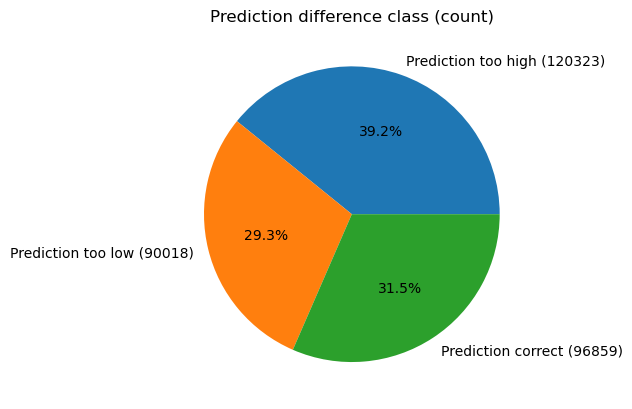

In [18]:
prediction_higher_than_target = np.count_nonzero(all_preds > all_targs)
prediction_lower_than_target = np.count_nonzero(all_preds < all_targs)
prediction_equal_to_target = np.count_nonzero(all_preds == all_targs)
labels = [
    f"Prediction too high ({prediction_higher_than_target})",
    f"Prediction too low ({prediction_lower_than_target})",
    f"Prediction correct ({prediction_equal_to_target})",
]

plt.pie(
    [
        prediction_higher_than_target,
        prediction_lower_than_target,
        prediction_equal_to_target,
    ],
    labels=labels,
    autopct="%1.1f%%",
)
plt.title("Prediction difference class (count)")
plt.show()

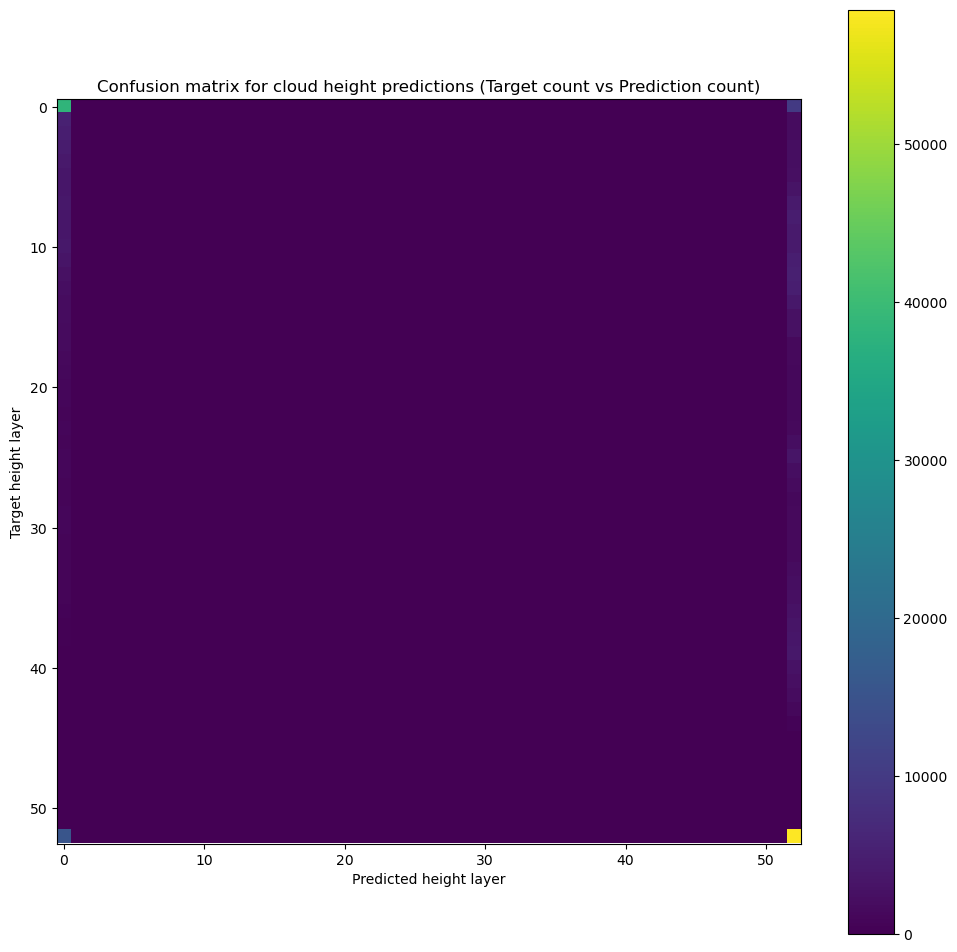


Model predictions binned: (Class label, Count): ((0.0, 128379), (69.0, 178821)) 

Target labels binned: (Class label, Count): ((0.0, 48207), (1.0, 7345), (2.0, 6824), (3.0, 6581), (4.0, 6311), (5.0, 5855), (6.0, 6811), (7.0, 8105), (8.0, 8406), (9.0, 7745), (10.0, 8055), (11.0, 8211), (12.0, 7782), (13.0, 7082), (14.0, 5604), (15.0, 4535), (16.0, 4367), (17.0, 3159), (18.0, 2949), (19.0, 2475), (20.0, 2263), (21.0, 2132), (22.0, 2052), (23.0, 2493), (24.0, 3018), (25.0, 4325), (26.0, 3172), (27.0, 2532), (28.0, 2182), (29.0, 2454), (30.0, 2408), (31.0, 2293), (32.0, 2251), (33.0, 2644), (34.0, 3003), (35.0, 3200), (36.0, 3398), (37.0, 3574), (38.0, 3818), (39.0, 3882), (40.0, 2967), (41.0, 2353), (42.0, 1856), (43.0, 1379), (44.0, 686), (45.0, 233), (46.0, 212), (47.0, 50), (48.0, 12), (49.0, 4), (50.0, 4), (51.0, 4), (69.0, 73937))


In [19]:
# sedi like a,b,d,c mean confusion matrix

plt.figure(figsize=(12, 12))

confm = confusion_matrix(all_targs, all_preds)
plt.imshow(confm, cmap=plt.cm.viridis, interpolation="nearest")
plt.colorbar()
plt.title(
    "Confusion matrix for cloud height predictions (Target count vs Prediction count)"
)
plt.ylabel("Target height layer")
plt.xlabel("Predicted height layer")
plt.show()

labels, counts = np.unique(all_preds, return_counts=True)
bins_pred = tuple(zip(list(labels), list(counts)))
labels, counts = np.unique(all_targs, return_counts=True)
bins_targ = tuple(zip(list(labels), list(counts)))
print("\nModel predictions binned: (Class label, Count):", bins_pred, "\n")
print("Target labels binned: (Class label, Count):", bins_targ)

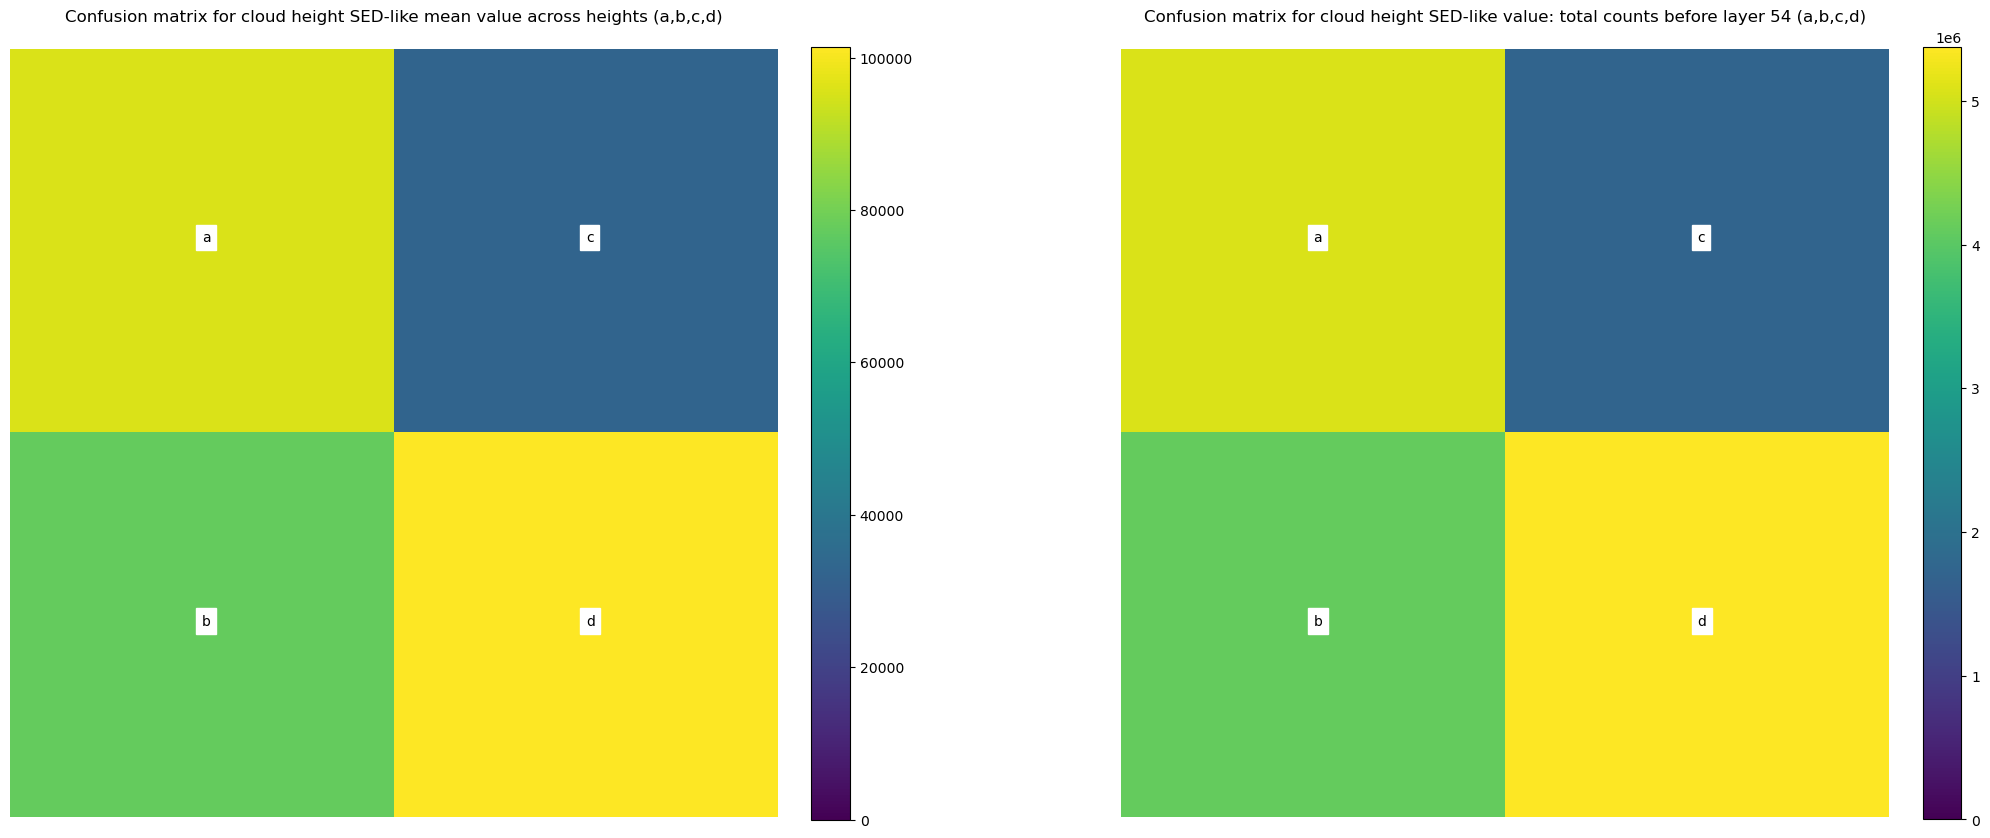

In [20]:
sed_like_conf_matrix = np.reshape(np.mean(np.array(abcd_list).T, axis=1), (2, 2))
labels = ["a", "b", "c", "d"]
fig = plt.figure(figsize=(20, 24))

from matplotlib import colors

divnorm = colors.Normalize(vmin=0.0)
divnorm2 = colors.Normalize(vmin=0.0)

ax1 = fig.add_subplot(121)
im = ax1.imshow(
    sed_like_conf_matrix, cmap=plt.cm.viridis, interpolation="nearest", norm=divnorm
)
for i, lab in enumerate(labels):
    ax1.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im, fraction=0.046, pad=0.04)
ax1.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like mean value across heights (a,b,c,d)",
    pad=20,
)


sed_like_conf_matrix_counts = np.reshape(
    np.sum(np.array(abcd_list[0:54]).T, axis=1), (2, 2)
)
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(
    sed_like_conf_matrix_counts,
    cmap=plt.cm.viridis,
    interpolation="nearest",
    norm=divnorm2,
)
for i, lab in enumerate(labels):
    ax2.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im2, fraction=0.046, pad=0.04)
ax2.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like value: total counts before layer 54 (a,b,c,d)",
    pad=20,
)
plt.tight_layout(w_pad=15)

plt.show()

## Finally, show the training info for this experiment

In [21]:
# init mlflow connection 
mlflow_server_address = 'vld425'
mlflow_server_port = 5001
mlflow_server_uri = f'http://{mlflow_server_address}:{mlflow_server_port:d}'
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_server_uri)

In [22]:
print(mlflow_client.search_experiments())

[<Experiment: artifact_location='./mlflow_artifacts/3', creation_time=1668080389494, experiment_id='3', last_update_time=1668080389494, lifecycle_stage='active', name='cbh-hparam-tuning', tags={}>, <Experiment: artifact_location='./mlflow_artifacts/2', creation_time=1666859727834, experiment_id='2', last_update_time=1666859727834, lifecycle_stage='active', name='cbh-label-model-runs', tags={}>, <Experiment: artifact_location='./mlflow_artifacts/1', creation_time=1666859713506, experiment_id='1', last_update_time=1666859713506, lifecycle_stage='active', name='test-setup-for-model-runs', tags={}>]


In [23]:
experiment_id = 1
runs = mlflow_client.search_runs(experiment_ids=1)
desired_run = [run for run in runs if run.info.run_id==model_run_hash][0]
print("Run metrics:",desired_run.data.metrics)
print("\nRun Hyperparams:", desired_run.data.params)

Run metrics: {'Val loss': 3.012204647064209, 'Train loss': 2.7004072666168213, 'epoch': 0.0, 'val_loss_mean': 3.0362415313720703, 'Single batch example validation metrics/Correct samples': 762.0, 'Single batch example validation metrics/Total samples tested': 2080.0, 'Single batch example validation metrics/Accuracy': 36.63461538461538}

Run Hyperparams: {'CPU Count': '12', 'Compute Memory': '64', 'Limited sample number': '-1', 'Random seed': '42', 'Model defined hparams/input_size': '210', 'Model defined hparams/ff_nodes': '[256, 256, 256]', 'Model defined hparams/output_size': '70', 'Model defined hparams/lr': '0.001', 'Model defined hparams/activation': 'relu', 'Model defined hparams/layer_num': '3', 'Max epochs': '1', 'Batch size': '2080', 'Data loaded into memory': 'False', 'data loader hparams/batch_size': '2080', 'data loader hparams/num_workers': '0', 'data loader hparams/collate_fn': 'None', 'data loader hparams/thread_count_for_dask': '12', 'data loader hparams/shuffle_traini

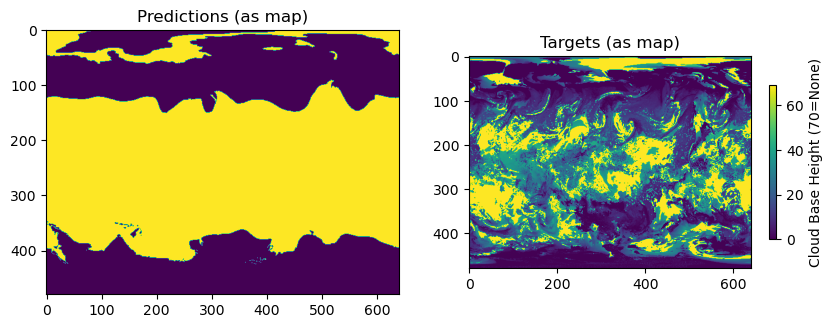

In [61]:
reshp_preds = all_preds.reshape(480, 640)
reshp_targ = all_targs.reshape(480, 640)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
plt.title("Predictions (as map)")
pos1 = ax1.imshow(reshp_preds)
ax2 = fig.add_subplot(122)
plt.title("Targets (as map)")
pos = ax2.imshow(reshp_targ)
fig.colorbar(pos, ax=ax2, shrink=0.2, label="Cloud Base Height (70=None)")
plt.show()

In [71]:
from scipy.special import softmax

In [75]:
all_pred_distributions = []
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    x = torch.flatten(x, start_dim=1)
    batch_preds = model(x)  # self call = forward
    all_pred_distributions.append(softmax(batch_preds.detach().numpy(), axis=1))
all_pred_distributions = np.array(all_pred_distributions[0])

In [80]:
print(all_pred_distributions[0])

[4.0995768e-01 2.6183797e-02 3.1621121e-02 3.6825653e-02 4.1378383e-02
 4.1450538e-02 4.0558398e-02 3.3316039e-02 2.9953394e-02 2.3870951e-02
 1.9094434e-02 1.4663163e-02 1.2748520e-02 1.1678971e-02 1.1030741e-02
 9.7556077e-03 8.4501309e-03 8.9550968e-03 6.5782508e-03 8.5697351e-03
 7.2075832e-03 5.8979653e-03 6.0012746e-03 7.1308753e-03 5.4817759e-03
 4.0409132e-03 4.4061341e-03 4.4276631e-03 3.6633401e-03 3.7761054e-03
 2.8233202e-03 1.8802130e-03 1.2245127e-03 6.8193278e-04 4.3290490e-04
 1.1060425e-04 3.7029338e-05 1.2162807e-05 2.6238577e-06 3.1263357e-07
 3.3332686e-09 6.3158645e-11 8.9620394e-12 2.6329835e-12 1.5531449e-12
 4.8269548e-12 1.6919487e-10 6.9264972e-10 1.6889112e-10 2.3113934e-10
 3.1194691e-10 6.3929691e-12 4.2680543e-11 6.2175703e-10 5.0677827e-11
 1.1676944e-10 4.9910218e-11 3.8867153e-11 2.6156360e-11 4.7420359e-11
 8.6165443e-11 6.4352773e-11 1.0901186e-10 9.3474638e-11 3.8914330e-11
 9.7022279e-11 1.4110359e-10 1.6440205e-10 2.2117735e-10 1.1412013e-01]


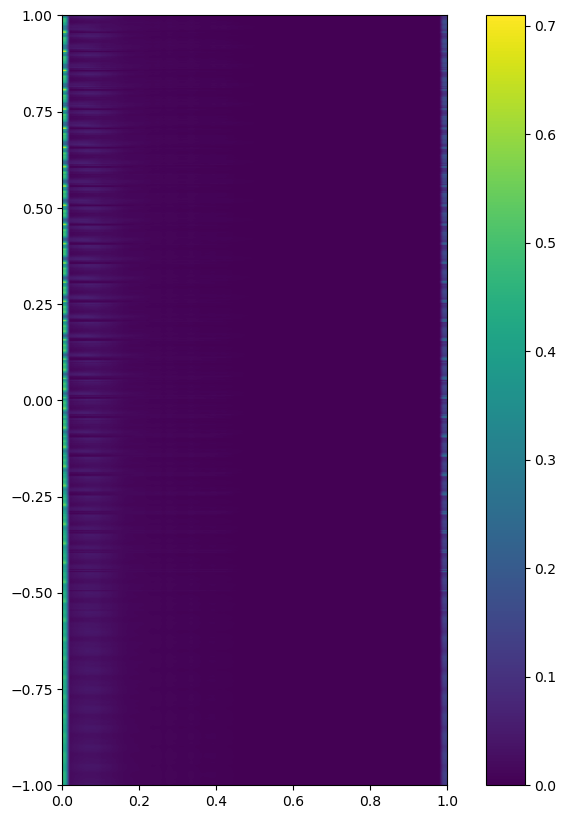

In [98]:
plt.figure(figsize=(10,10))
plt.imshow(all_pred_distributions, extent=[0,1,-1,1])
plt.colorbar()
plt.show()